In [26]:
import tensorflow as tf
keras = tf.keras
layers = tf.keras.layers
initializers = tf.keras.initializers

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from data_generator import generator
from encoding.layers import IntegerBaseEncoder

In [2]:
seed = 123
tf.random.set_seed(seed)
gen = generator.DataGenerator(mean=15, std=4, is_int=True)
x, y = gen.generate(n_features=1, n_samples=100)

x = np.ravel(x)
order = np.argsort(x).reshape(-1, 1)
x, y = x[order], y[order]
x_exp = np.power(2, x)
y_exp = np.power(2, y)
x_log = np.log(x)
y_log = np.log(y)

In [3]:
standard = lambda x:(x - x.mean())/x.std()

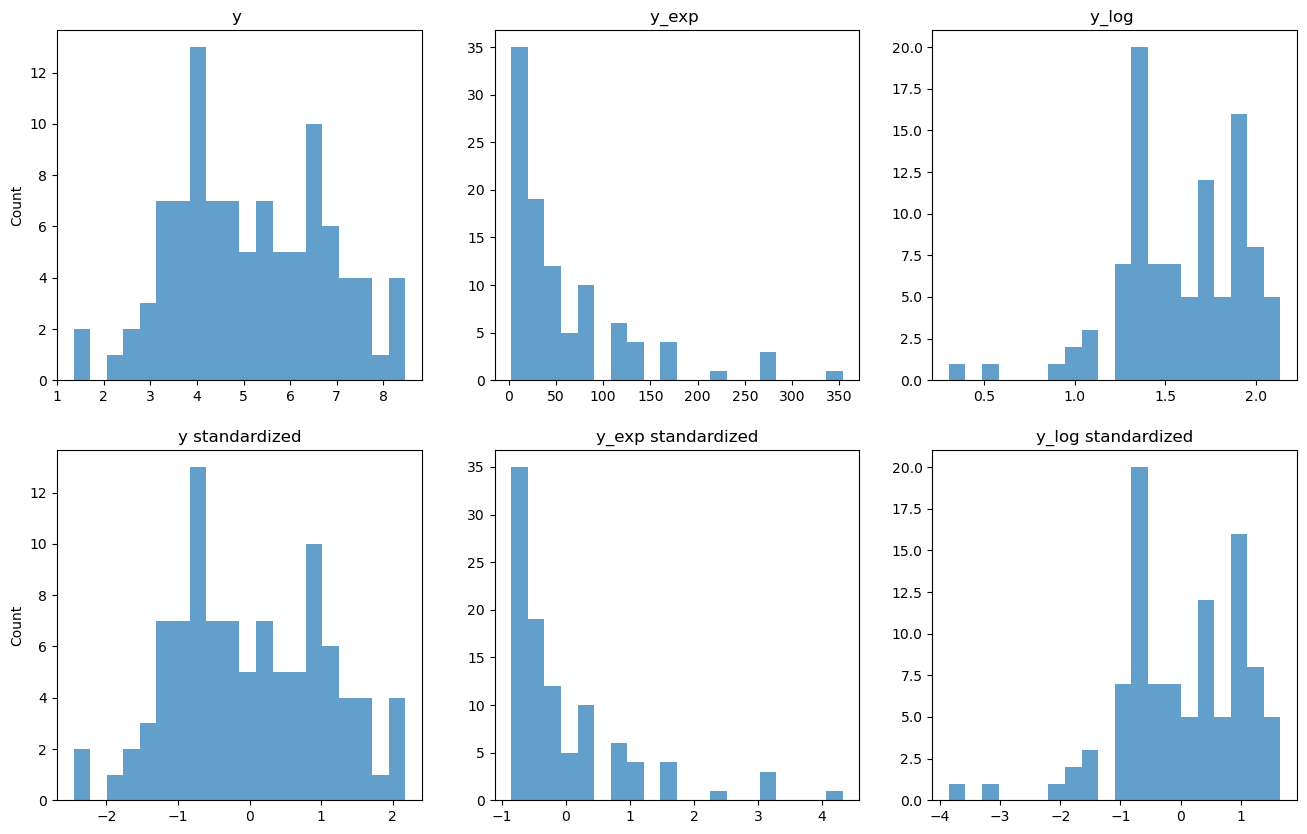

In [4]:
fig, ax = plt.subplots(2, 3, figsize=(16,10))
kwargs = {'bins': 20}

for idx, name in enumerate( ['y', 'y_exp', 'y_log']):
    for idy, standard_name in enumerate(['', 'standardized']):
        cur = eval(name)
        if standard_name:
            cur = standard(cur)
        ax[idy, idx].hist(cur, alpha=0.7, **kwargs)
        ax[idy, idx].set_title(name + f' {standard_name}')
    
ax[0, 0].set(ylabel='Count')
ax[1, 0].set(ylabel='Count')

plt.show()

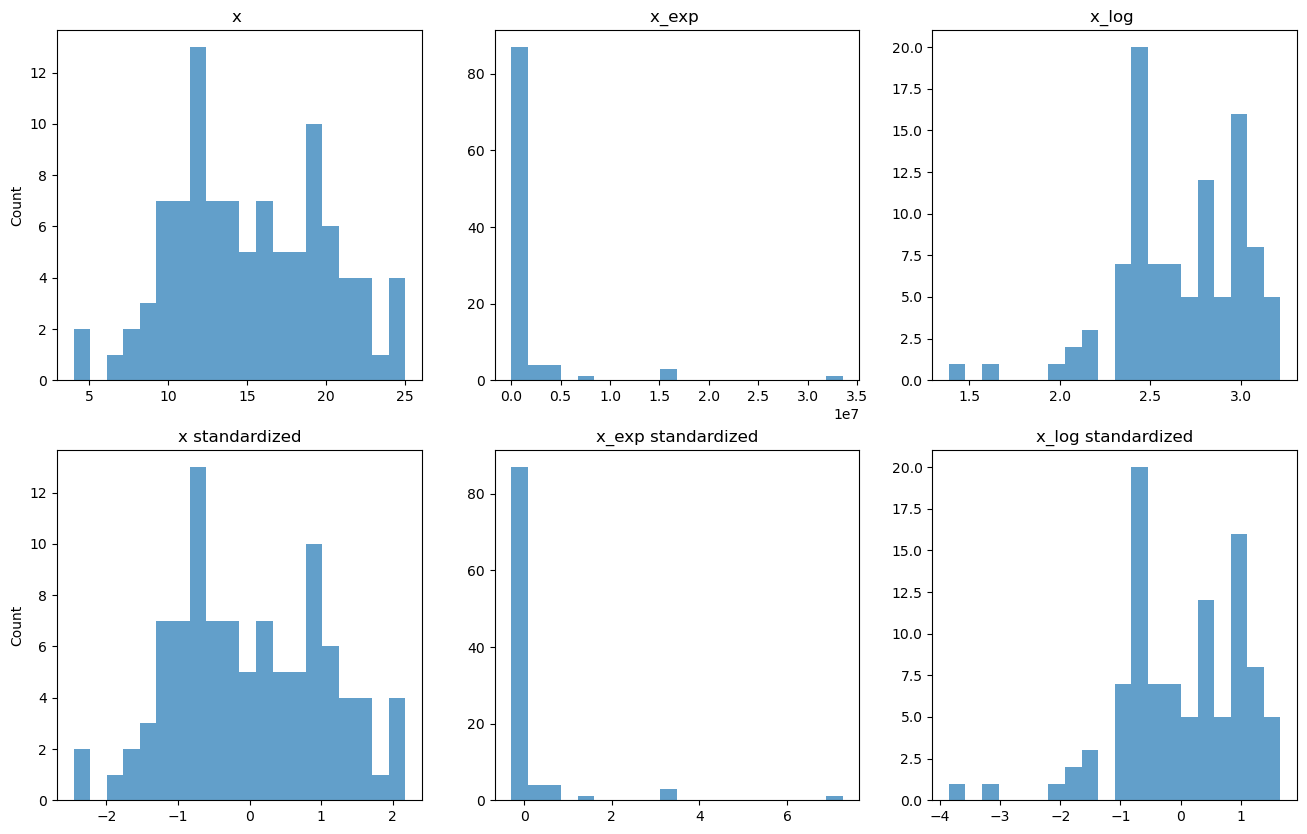

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(16,10))
kwargs = {'bins': 20}

for idx, name in enumerate( ['x', 'x_exp', 'x_log']):
    for idy, standard_name in enumerate(['', 'standardized']):
        cur = eval(name)
        if standard_name:
            cur = standard(cur)
        ax[idy, idx].hist(cur, alpha=0.7, **kwargs)
        ax[idy, idx].set_title(name + f' {standard_name}')
    
ax[0, 0].set(ylabel='Count')
ax[1, 0].set(ylabel='Count')

plt.show()

2023-02-04 15:24:31.865835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 15:24:31.866068: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/local/cuda/lib64:
2023-02-04 15:24:31.866144: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/local/cuda/lib64:
2023-02-04 15:24:31.866215: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.

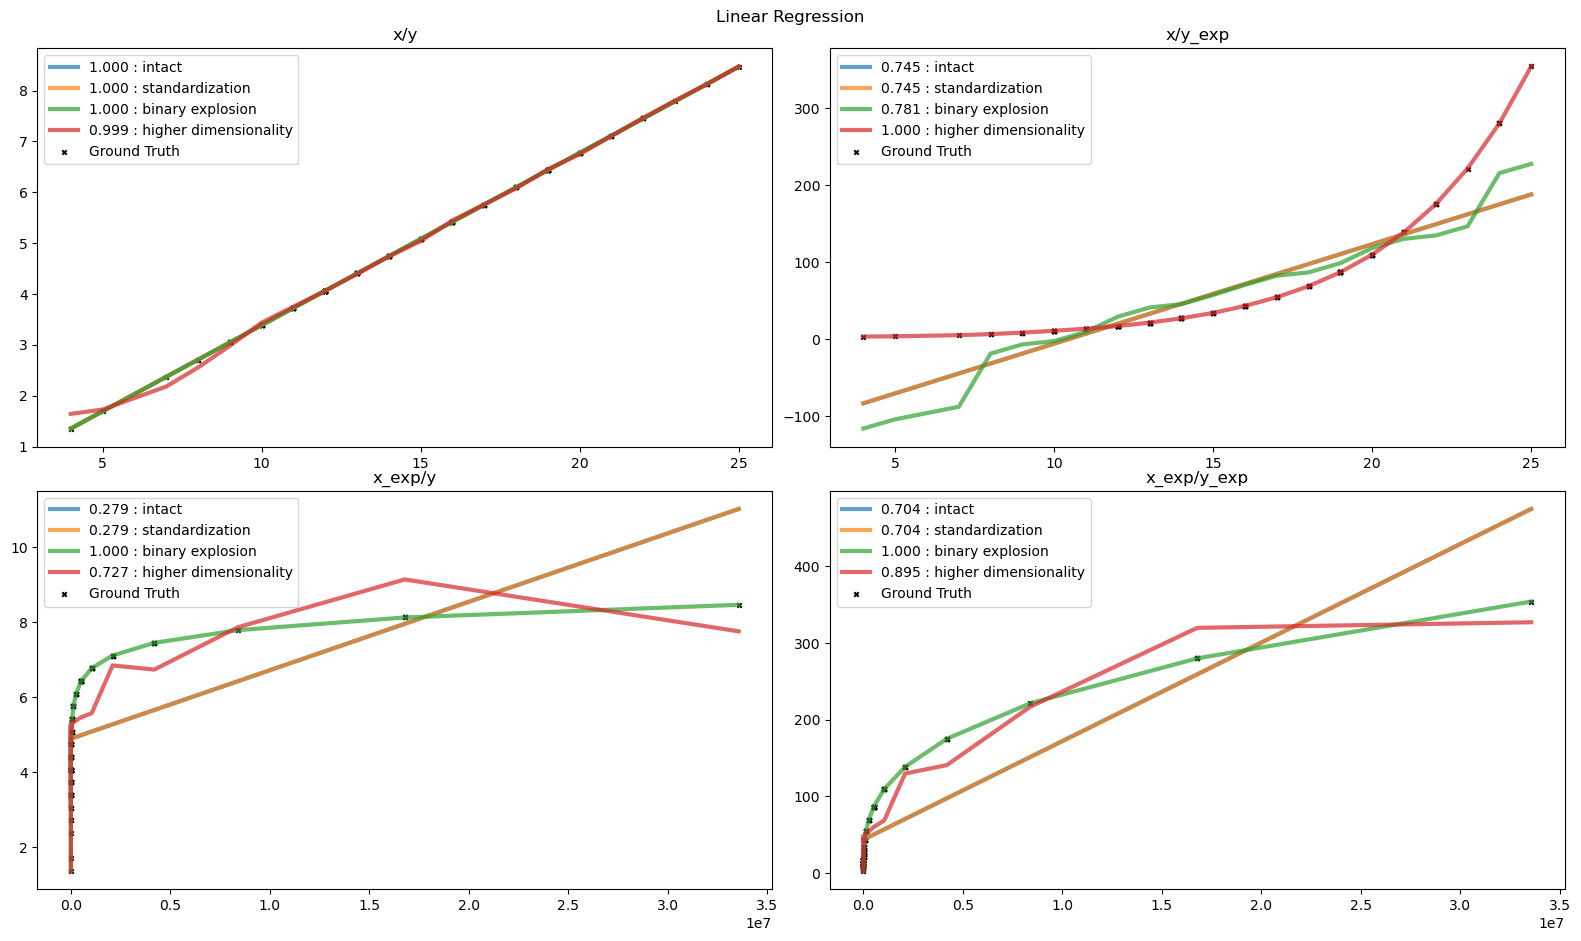

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))
fig.tight_layout()
transform_layer = IntegerBaseEncoder()
x_array = ['x', 'x_exp']
y_array = ['y', 'y_exp']
tranformations = {'intact': lambda x: x,
                  'standardization': standard,
                  'binary explosion': lambda x: transform_layer(x).squeeze(1),
                  'higher dimensionality': lambda x, n=20: np.power(x, np.arange(1, n))}
baseline = LinearRegression
# for idx, x_name in enumerate(['x', 'x_exp', 'x_log']):
#     for idy, y_name in enumerate(['y', 'y_exp', 'y_log']):
for idx, x_name in enumerate(x_array):
    for idy, y_name in enumerate(y_array):
        cur_x, cur_y = eval(x_name), eval(y_name)

        for name_transformation, func_transformation in tranformations.items():
            transformed_x = func_transformation(cur_x)
            model = baseline()
            model.fit(transformed_x, cur_y)
            y_hat = model.predict(transformed_x)
            score = model.score(transformed_x, cur_y)
            ax[idx, idy].plot(cur_x, y_hat, '-', alpha=0.7, linewidth=3, label=f'{score:0.3f} : {name_transformation}')


        ax[idx, idy].scatter(cur_x, cur_y, c='black', marker='x', label=f'Ground Truth', s=10)

        ax[idx, idy].set_title(f'{x_name}/{y_name}')
        ax[idx, idy].legend()
plt.suptitle('Linear Regression', y=1.02)
plt.show()

In [67]:
class _MLPBlock(keras.layers.Layer):
    def __init__(self, width, droprate=0, regularization=keras.regularizers.L1L2(0), **kwargs):
        super(_MLPBlock, self).__init__()
        self.dense = layers.Dense(width, 
                                  kernel_initializer=initializers.RandomNormal(seed=seed),
                                  kernel_regularizer=regularization, **kwargs)
#         self.activation = layers.ReLU()
#         self.drop = layers.Dropout(droprate)
#         self.bn = layers.BatchNormalization()
        
    def call(self, inputs, **kwargs):
        x = self.dense(inputs)
#         x = self.activation(x)
#         x = self.drop(x)
#         x = self.bn(x)
        return x

# implement policy network
class MLP(keras.Model):
    def __init__(self, input_dim, output_dim, hidden_dim=64, depth=1, **kwargs):
        super().__init__()
        self.depth = depth
        self.hidden_0 = _MLPBlock(hidden_dim, input_shape=(input_dim,), **kwargs)

        for i in range(1, depth):
            setattr(self, f'hidden_{i}', _MLPBlock(hidden_dim))
        self.out = _MLPBlock(output_dim)

    
    def call(self, inputs):
        x = inputs
        for i in range(self.depth):
            x = getattr(self, f'hidden_{i}')(x)
        x = self.out(x)
        return x

4/4 [==============================] - 0s 3ms/step
intact 0.0007047972742586775
4/4 [==============================] - 0s 2ms/step
standardization 2.742665359638096e-05
4/4 [==============================] - 0s 2ms/step
binary explosion 6.5471372740274615e-06
4/4 [==============================] - 0s 2ms/step
higher dimensionality 0.0014552272653623822
4/4 [==============================] - 0s 3ms/step
intact 1313.776109590433
4/4 [==============================] - 0s 3ms/step
standardization 1181.2847301411002
4/4 [==============================] - 0s 2ms/step
binary explosion 1421.1443132044124
4/4 [==============================] - 0s 2ms/step
higher dimensionality 38.979181661486294
4/4 [==============================] - 0s 2ms/step
intact 0.8992741308747424
4/4 [==============================] - 0s 2ms/step
standardization 1.690364166589526
4/4 [==============================] - 0s 2ms/step
binary explosion 3.369478421809311e-05
4/4 [==============================] - 0s 2ms/step
h

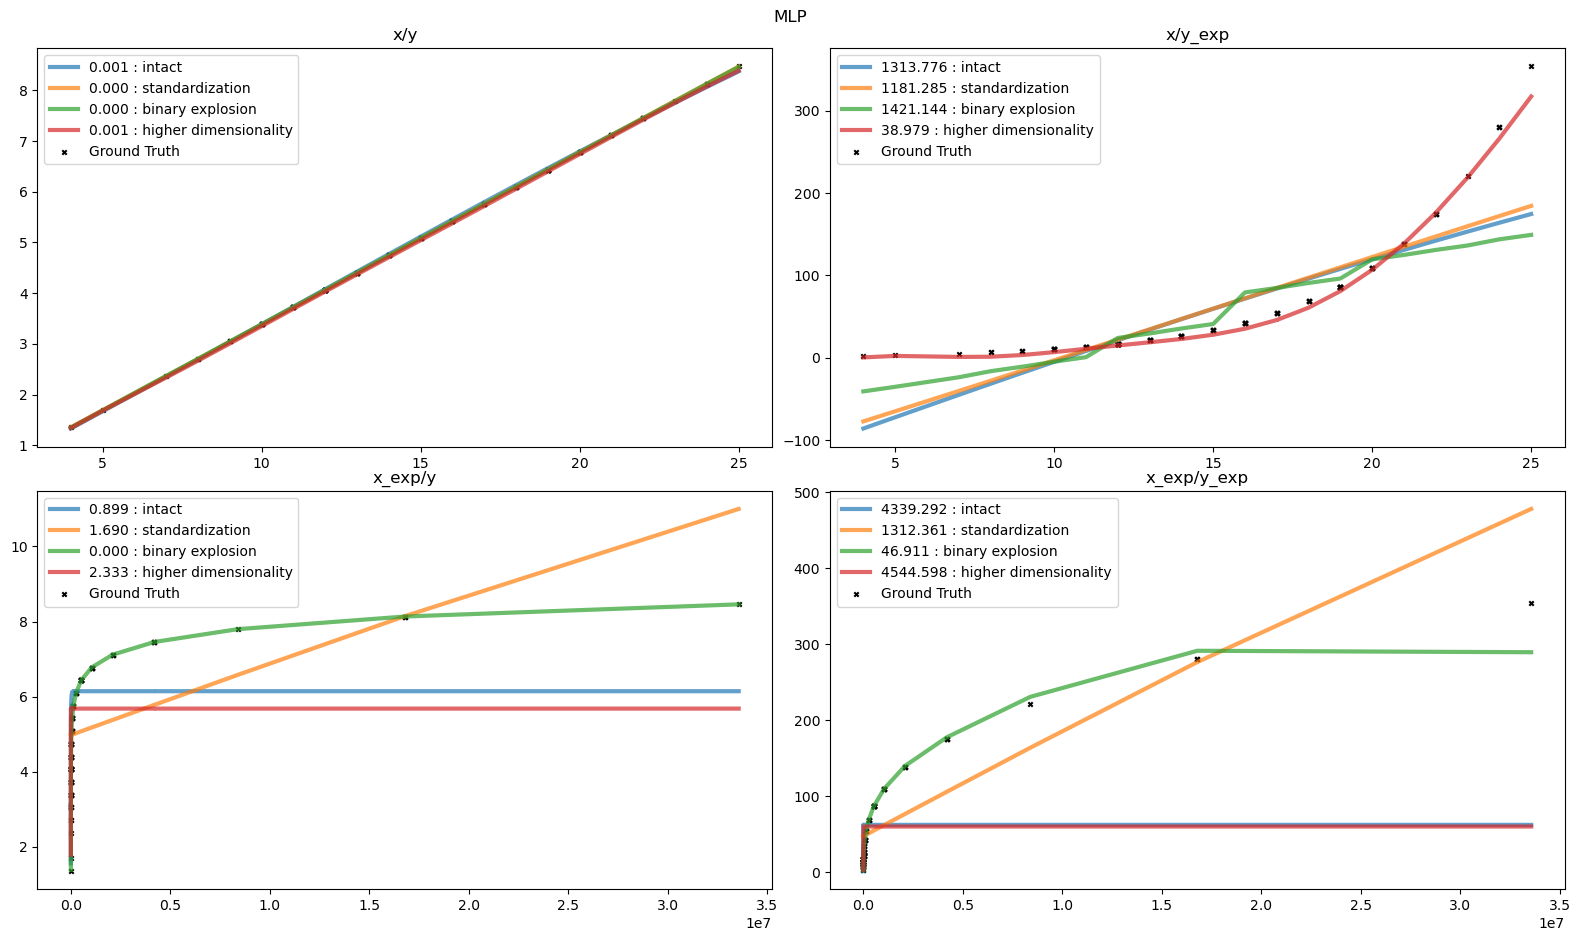

In [79]:
x_array = ['x', 'x_exp']
y_array = ['y', 'y_exp']

fig, ax = plt.subplots(2, 2, figsize=(16, 9))
fig.tight_layout()
transform_layer = IntegerBaseEncoder()
activation = activation=keras.activations.sigmoid
tranformations = {'intact': lambda x: x,
                  'standardization': standard,
                  'binary explosion': lambda x: transform_layer(x).squeeze(1),
                  'higher dimensionality': lambda x, n=3: np.power(x, np.arange(1, n))}


for idx, x_name in enumerate(x_array):
    for idy, y_name in enumerate(y_array):
        cur_x, cur_y = eval(x_name), eval(y_name)
        

        for name_transformation, func_transformation in tranformations.items():
            transformed_x = func_transformation(cur_x)
            try:
                model = MLP(transformed_x.shape[1], 1, 512, depth=4, activation=activation)
                model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
                model.fit(transformed_x, cur_y, epochs=500, verbose=0)
                y_hat = model.predict(transformed_x)
                score = mse(y_hat, cur_y)
                print(name_transformation, score)
                ax[idx, idy].plot(cur_x, y_hat, '-', alpha=0.7, linewidth=3, label=f'{score:0.3f} : {name_transformation}')
            except:
                print(name_transformation, 'NANS')


        ax[idx, idy].scatter(cur_x, cur_y, c='black', marker='x', label=f'Ground Truth', s=10)

        ax[idx, idy].set_title(f'{x_name}/{y_name}')
        ax[idx, idy].legend()
plt.suptitle('MLP', y=1.02)
plt.show()

In [ ]:
cur_x = x_exp
cur_y = y

transformed_x = tranformations['intact'](cur_x)
model = MLP(transformed_x.shape[1], 1, 128, depth=100)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1), loss='mse')
model.fit(transformed_x, cur_y, epochs=100, verbose=1)

y_hat = model.predict(transformed_x)
score = mse(y_hat, cur_y)
plt.plot(cur_x, y_hat, '-', alpha=0.7, linewidth=3, label=f'{score:0.3f} : intact')
plt.scatter(cur_x, cur_y, c='black', marker='x', label=f'Ground Truth', s=10)
plt.legend()
plt.plot()